In [2]:
import os, time
import numpy as np 
from tqdm import tqdm 
from string import punctuation
from collections import Counter 
import matplotlib.pyplot as plt

import torch 
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import gzip

c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SEED = 1004
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(SEED)

In [68]:
# review_list, label_list = [], []
# for label in ['pos', 'neg']:
#     for fname in tqdm(os.listdir(f'./aclImdb/train/{label}/')):
#         if 'txt' not in fname:
#             continue 
        
#         with open(
#             os.path.join(f'./aclImdb/train/{label}/', fname), encoding='utf-8'
#         ) as f:
#             review_list += [f.read()]
#             label_list += [label]


# import random 
# sample = random.sample(range(25000), 10000)


# review_lists = list(np.array(review_list)[sample])
# label_lists = list(np.array(label_list)[sample])


# with open(f'./data.txt', 'w', encoding='utf-8-sig') as f:
#     for review, label in zip(review_lists, label_lists):
#         f.write(f'{review}\t{label}\n')

100%|██████████| 12500/12500 [00:32<00:00, 383.54it/s]


In [89]:
PATH = os.path.join(os.getcwd(), 'reviews.txt')
review_list, label_list = [], []
with open(PATH, 'r', encoding='utf-8-sig') as datasets:
    for d_set in datasets:
        d_set = d_set.strip()
        review, label = d_set[:-3], d_set[-3:] # pos, neg
        review_list.append(review)
        label_list.append(label)

### Preprocessing

In [91]:
review_list = [review.lower() for review in review_list]
review_list = [
    ''.join([letter for letter in review if letter not in punctuation]) for review in tqdm(review_list)
] # remove punctuation

reviews_blob = ' '.join(review_list)

review_words = reviews_blob.split()

count_words = Counter(review_words)

total_review_words = len(review_words)
sorted_review_words = count_words.most_common(total_review_words)

# the most of words are stop words

100%|██████████| 10000/10000 [00:00<00:00, 33429.75it/s]


In [92]:
# build vocaburary
vocab_to_token = {
    word:idx + 1 for idx, (word, count) in enumerate(sorted_review_words)
}

# word to token 
reviews_tokenized = []

for review in review_list:
    word_to_token = [vocab_to_token[word] for word in review.split()]
    reviews_tokenized.append(word_to_token) # the -> 1, and -> 2

In [93]:
label_list

['pos',
 'pos',
 'neg',
 'neg',
 'pos',
 'neg',
 'neg',
 'pos',
 'pos',
 'pos',
 'neg',
 'neg',
 'neg',
 'pos',
 'neg',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'neg',
 'neg',
 'pos',
 'pos',
 'pos',
 'neg',
 'neg',
 'neg',
 'pos',
 'neg',
 'pos',
 'neg',
 'neg',
 'neg',
 'neg',
 'pos',
 'neg',
 'neg',
 'neg',
 'pos',
 'neg',
 'neg',
 'neg',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'pos',
 'neg',
 'neg',
 'neg',
 'pos',
 'pos',
 'pos',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'pos',
 'pos',
 'pos',
 'neg',
 'neg',
 'neg',
 'neg',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'pos',
 'neg',


In [94]:
encoded_label_list = [1 if label == 'pos' else 0 for label in label_list]

reviews_len = [len(review) for review in reviews_tokenized]

reviews_tokenized = [
    reviews_tokenized[i] for i, l in enumerate(reviews_len) if l > 0 
]

encoded_label_list = np.array(
    [encoded_label_list[i] for i, l in enumerate(reviews_len) if l > 0], dtype='float32'
)

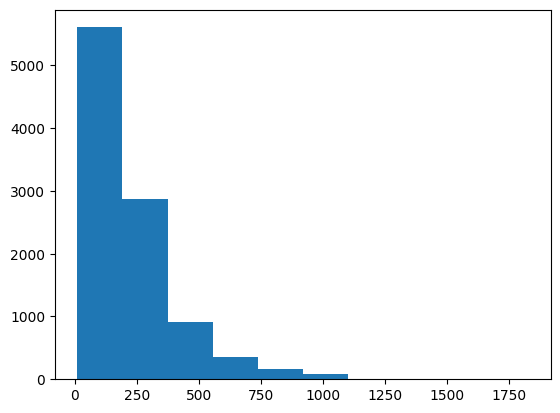

In [95]:
def pad_sequence(reviews_tokenized, sequence_length):
    padded_reviews = np.zeros((len(reviews_tokenized), sequence_length), dtype=int)
    
    for idx, review in enumerate(reviews_tokenized):
        review_len = len(review)
        
        if review_len <= sequence_length:
            zeroes = list(np.zeros(sequence_length - review_len))
            new_sequence = zeroes + review # zero padding 
            
        elif review_len > sequence_length:
            new_sequence = review[:sequence_length]
            
        padded_reviews[idx, :] = np.array(new_sequence)
    
    return padded_reviews

sequence_length = 512 
padded_reviews = pad_sequence(
    reviews_tokenized = reviews_tokenized, sequence_length=sequence_length
)

plt.hist(reviews_len);

In [96]:
train_valid_ratio = 0.75
train_x = padded_reviews[:int(train_valid_ratio*len(padded_reviews))]
train_y = encoded_label_list[:int(train_valid_ratio*len(padded_reviews))]

valid_x = padded_reviews[int(train_valid_ratio*len(padded_reviews)):]
valid_y = encoded_label_list[int(train_valid_ratio*len(padded_reviews)):]

### Build Dataset

In [97]:
class RNNDataset(Dataset):
    def __init__(self, X, y):
        super(RNNDataset, self).__init__()
        
        self.X = X 
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        
        return (
            torch.tensor(x), 
            torch.tensor(y)
        )

In [98]:
train_dataset = RNNDataset(train_x, train_y)
valid_dataset = RNNDataset(valid_x, valid_y)

In [99]:
valid_y.sum()

1250.0

In [100]:
batch_size = 512 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

### Model

In [115]:
class RNN(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, out_dim):
        super(RNN, self).__init__()
        self.embedding_layer = nn.Embedding(input_dim, emb_dim)
        self.rnn_layer = nn.RNN(emb_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc_layer = nn.Linear(hidden_dim, out_dim)
        
    def forward(self, seq):
        embed = self.embedding_layer(seq)
        o, h = self.rnn_layer(embed)
        outs = self.fc_layer(h[-1, :, :].squeeze(0))
        return outs 

In [118]:
def accuracy(pred, label):
    prediction = torch.round(torch.sigmoid(pred))
    accs = (prediction == label).sum() / len(label)
    return accs 

def train(model, dataloader, optimizer, criterion):
    losses, accs = 0, 0
    model.train()
    for seq, label in dataloader:
        seq = seq.to(device)
        label = label.to(device)
        preds = model(seq).squeeze()
        loss = criterion(preds, label)
        acc = accuracy(preds, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses += loss.item()
        accs += acc.item()
        
    return losses / len(dataloader), accs / len(dataloader )


def evaluate(model, dataloader, criterion):
    
    losses, accs = 0, 0
    model.eval()
    with torch.no_grad():
        for seq, label in dataloader:
            seq = seq.to(device)
            label = label.to(device)
            preds = model(seq).squeeze()
            loss = criterion(preds, label)
            acc = accuracy(preds, label)
            
            losses += loss.item()
            accs += acc.item()
            
    return loss / len(dataloader), accs / len(dataloader)

In [119]:
input_dim = len(vocab_to_token) + 1 
emb_dim = 128
hidden_dim = 32
out_dim = 1

rnn_model = RNN(input_dim, emb_dim, hidden_dim, out_dim).to(device)

optimizer = optim.Adam(rnn_model.parameters())
criterion = nn.BCEWithLogitsLoss().to(device)

### Model Train

In [153]:
num_epochs = 100
best_loss = float('inf')

for epoch in range(1, num_epochs + 1):
    
    train_loss, train_acc = train(rnn_model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(rnn_model, valid_loader, criterion)
    
    if best_loss > valid_loss:
        best_loss = valid_loss 
        torch.save(rnn_model.state_dict(), 'rnn_model.pt')
    
    if epoch % 10 == 0:
        print(f'epoch: [{epoch}/{num_epochs}]')
        print(f'train_loss: {train_loss:.4f}\t train_accuracy: {train_acc*100:.2f}%')
        print(f'valid_loss: {valid_loss:.4f}\t valid_accuracy: {valid_acc*100:.2f}%\n')
        

epoch: [10/100]
train_loss: 0.7105	 train_accuracy: 48.51%
valid_loss: 0.1412	 valid_accuracy: 48.49%

epoch: [20/100]
train_loss: 0.7105	 train_accuracy: 48.53%
valid_loss: 0.1439	 valid_accuracy: 48.40%

epoch: [30/100]
train_loss: 0.7105	 train_accuracy: 48.51%
valid_loss: 0.1427	 valid_accuracy: 48.44%

epoch: [40/100]
train_loss: 0.7107	 train_accuracy: 48.46%
valid_loss: 0.1435	 valid_accuracy: 48.54%

epoch: [50/100]
train_loss: 0.7106	 train_accuracy: 48.46%
valid_loss: 0.1405	 valid_accuracy: 48.53%

epoch: [60/100]
train_loss: 0.7105	 train_accuracy: 48.51%
valid_loss: 0.1438	 valid_accuracy: 48.42%

epoch: [70/100]
train_loss: 0.7108	 train_accuracy: 48.41%
valid_loss: 0.1423	 valid_accuracy: 48.43%

epoch: [80/100]
train_loss: 0.7104	 train_accuracy: 48.55%
valid_loss: 0.1421	 valid_accuracy: 48.54%

epoch: [90/100]
train_loss: 0.7105	 train_accuracy: 48.50%
valid_loss: 0.1415	 valid_accuracy: 48.49%

epoch: [100/100]
train_loss: 0.7108	 train_accuracy: 48.46%
valid_loss: 0

### Evaluate

In [154]:
model_path = os.path.join(os.getcwd(), 'rnn_model.pt')

rnn_model = RNN(input_dim, emb_dim, hidden_dim, out_dim).to(device)
rnn_model.state_dict(torch.load(model_path))

OrderedDict([('embedding_layer.weight',
              tensor([[ 0.7665,  0.9837, -1.0978,  ...,  0.5815,  1.0364, -1.6115],
                      [ 0.7764,  0.9626, -0.6196,  ...,  0.8618, -1.6589,  0.6475],
                      [-1.3121, -0.2634, -0.1814,  ..., -0.1039, -0.0146, -1.9407],
                      ...,
                      [-0.0804, -0.6694, -0.5183,  ...,  0.6631, -0.8632, -1.3398],
                      [-0.0711, -2.4533, -0.8975,  ..., -0.1902, -0.1618,  0.9095],
                      [-1.6899,  1.6587, -1.4952,  ..., -1.1534, -0.9873, -0.3995]],
                     device='cuda:0')),
             ('rnn_layer.weight_ih_l0',
              tensor([[-0.1693,  0.0174, -0.1606,  ...,  0.1183,  0.0540,  0.1672],
                      [-0.0548, -0.0934,  0.1050,  ..., -0.0238, -0.0843, -0.1627],
                      [-0.0982, -0.1354,  0.0971,  ..., -0.0522, -0.1076, -0.1122],
                      ...,
                      [-0.0144,  0.0399, -0.0067,  ...,  0.1542,  0.0

In [155]:
def sample2feats(sample):
    sample = sample.lower()
    sample = ''.join([c for c in sample if c not in punctuation])
    tokenized = [vocab_to_token.get(token, 0) for token in sample.split()]
    tokenized = np.pad(tokenized, (512-len(tokenized), 0), 'constant')
    return tokenized
    
samples = ['So So happy!', 'this movie so terrible', 'This film is horrible', 'This film is very good', 'I loved the movie, every part of it']


In [156]:
infer = []
for sample in samples:
    infer.append(sample2feats(sample))
infer = torch.tensor(np.array(infer))

In [160]:
for sample in infer:
    sample = sample.to(device).unsqueeze(0)
    pred_y = rnn_model(sample)
    pred_y = torch.sigmoid(pred_y)
    
    print(pred_y.item())

0.5449953079223633
0.6242840886116028
0.49887457489967346
0.5197864174842834
0.5529115200042725
